In [306]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm

In [252]:
train_data = pd.read_csv("Files/train.csv")
test_data = pd.read_csv("Files/test.csv")

# number of nan values in each column
nan_values = pd.DataFrame(
    {"train": train_data.isna().mean() * train_data.shape[0], "test": test_data.isna().mean() * test_data.shape[0]}
)
nan_values

,train,test
Churn,0.0,NaN
ClientPeriod,0.0,0.0
HasChild,0.0,0.0
HasContractPhone,0.0,0.0
HasDeviceProtection,0.0,0.0
HasInternetService,0.0,0.0
HasMovieSubscription,0.0,0.0
HasMultiplePhoneNumbers,0.0,0.0
HasOnlineBackup,0.0,0.0
HasOnlineSecurityService,0.0,0.0


In [253]:
# number of empty cells in each column
empty_cells = pd.DataFrame(
    {"train": (train_data == " ").mean() * train_data.shape[0], "test": (test_data == " ").mean() * test_data.shape[0]}
)
empty_cells

,train,test
Churn,0.0,NaN
ClientPeriod,0.0,0.0
HasChild,0.0,0.0
HasContractPhone,0.0,0.0
HasDeviceProtection,0.0,0.0
HasInternetService,0.0,0.0
HasMovieSubscription,0.0,0.0
HasMultiplePhoneNumbers,0.0,0.0
HasOnlineBackup,0.0,0.0
HasOnlineSecurityService,0.0,0.0


In [254]:
# dropping empty cells in train data
train_data.replace(" ", np.nan, inplace=True)
train_data.dropna(inplace=True)

In [255]:
# replacing empty cells in test data to the average of the column
valid_test_data = test_data.replace(" ", np.nan)
valid_test_data.dropna(inplace=True)
average = valid_test_data["TotalSpent"].astype(float).mean()
test_data.replace(" ", average, inplace=True)
test_data["TotalSpent"] = test_data["TotalSpent"].astype(str)

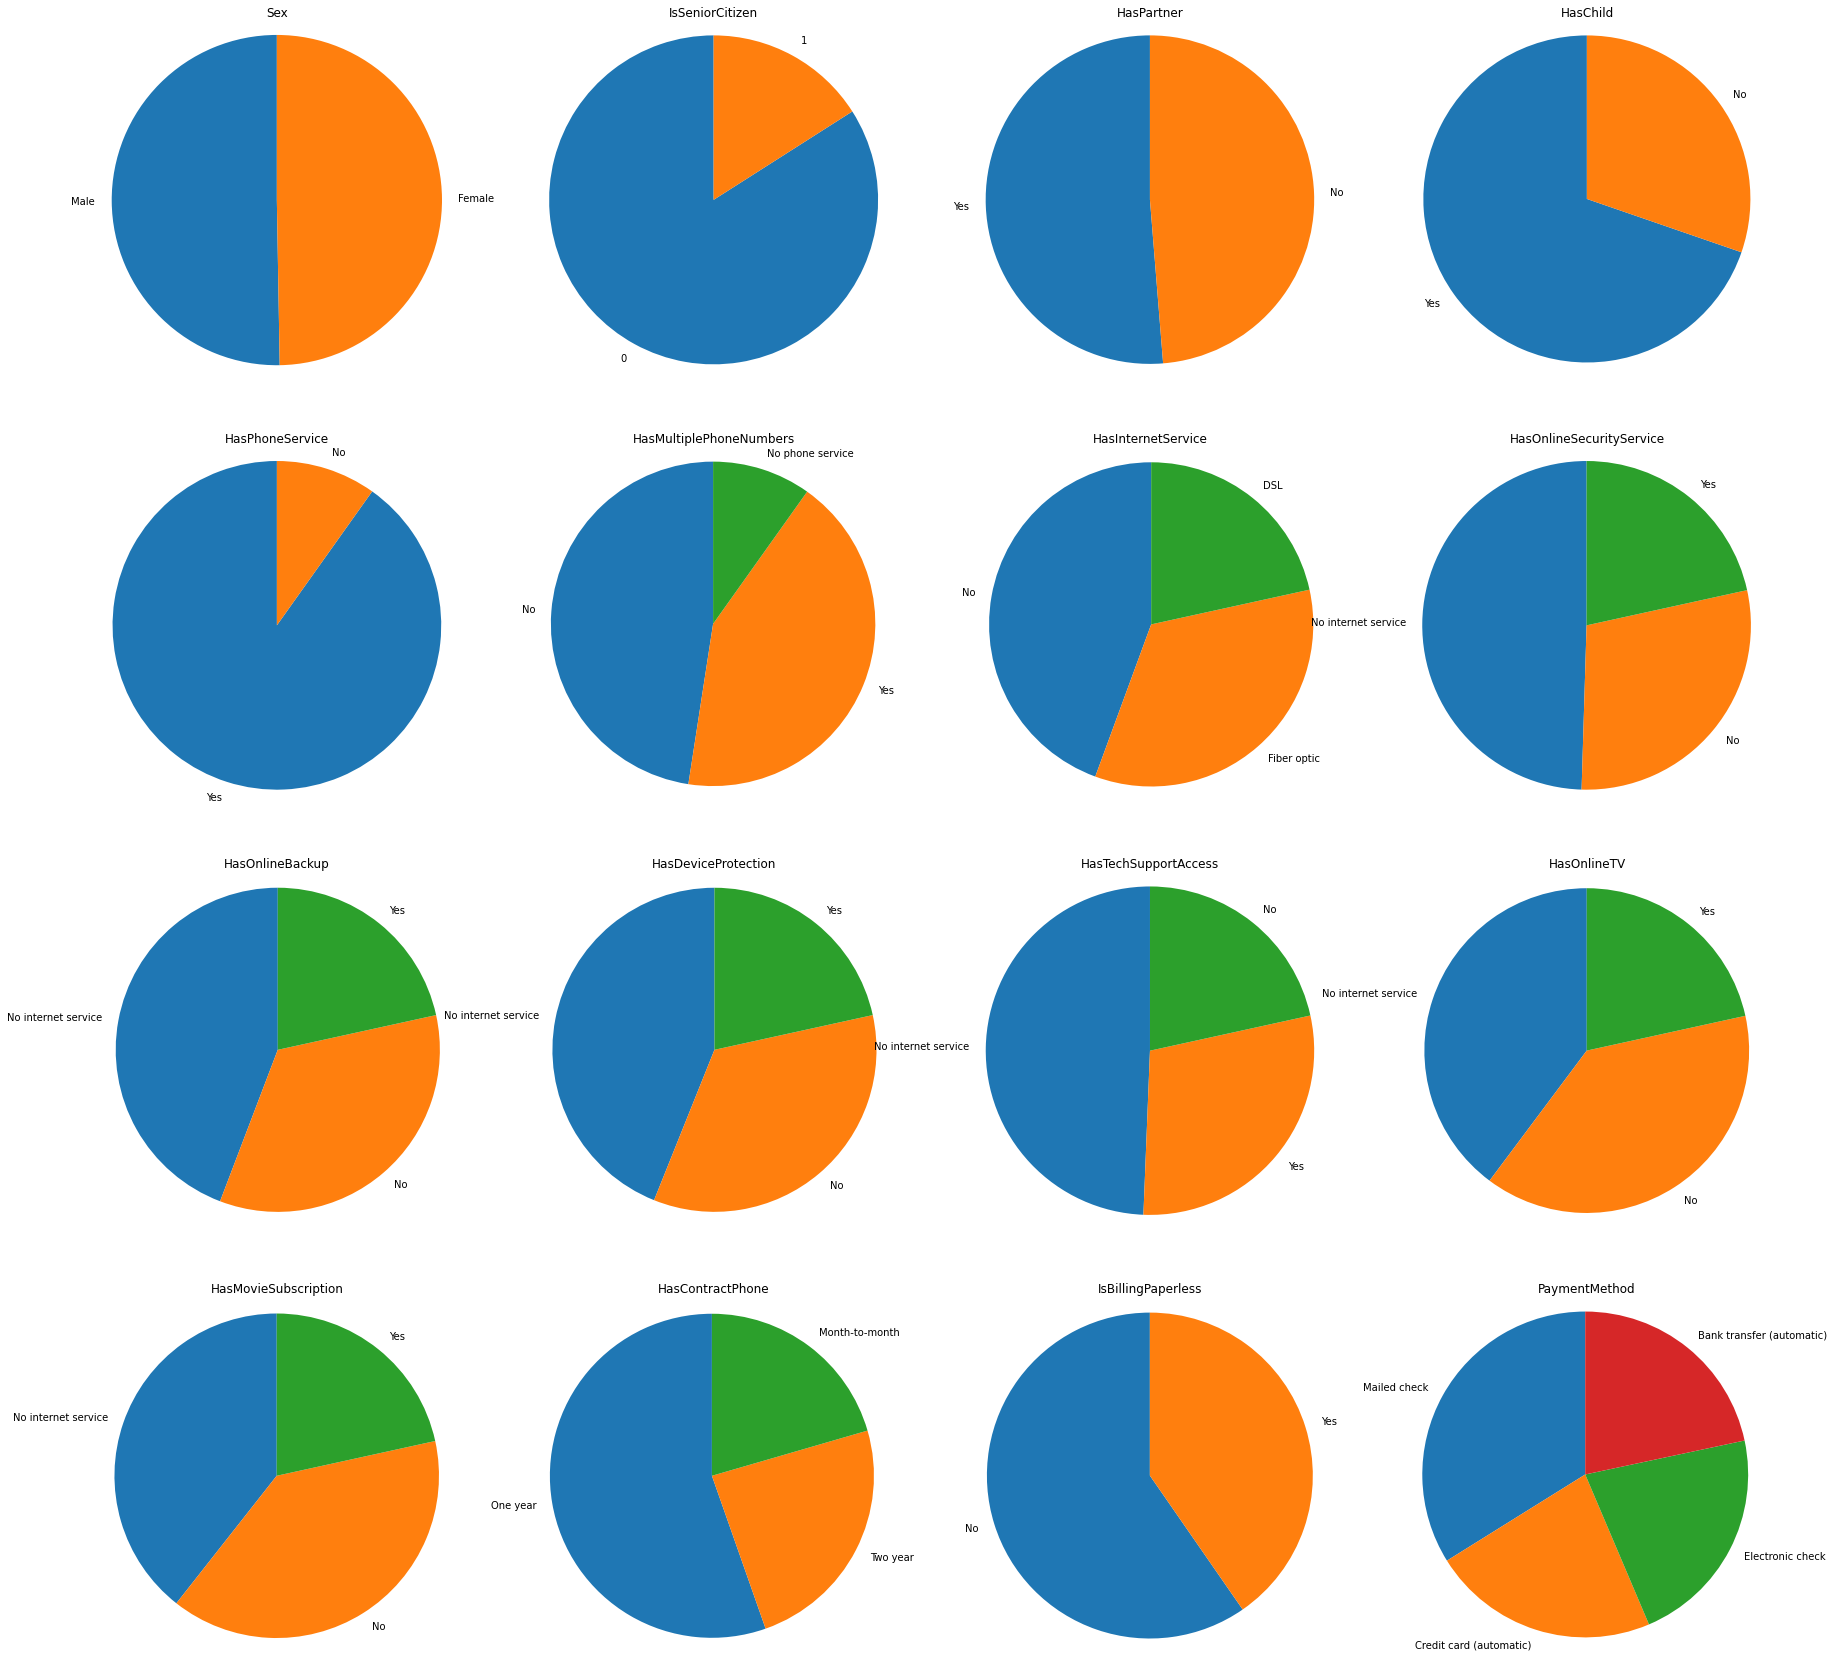

In [256]:
# working with categorical train data
categorical_columns = [column for column in train_data.columns if len(train_data[column].unique()) < 5]
del categorical_columns[-1]
train_categorical_data = train_data[categorical_columns]
figure, axes = plt.subplots(4, 4, figsize=(30, 30))
axes = axes.ravel()
for i, column in enumerate(categorical_columns):
    values = train_categorical_data[column].unique()
    values_count = train_categorical_data[column].value_counts()
    axes[i].set_title(column)
    axes[i].pie(values_count, labels=values, startangle=90)
    axes[i].axis("equal")

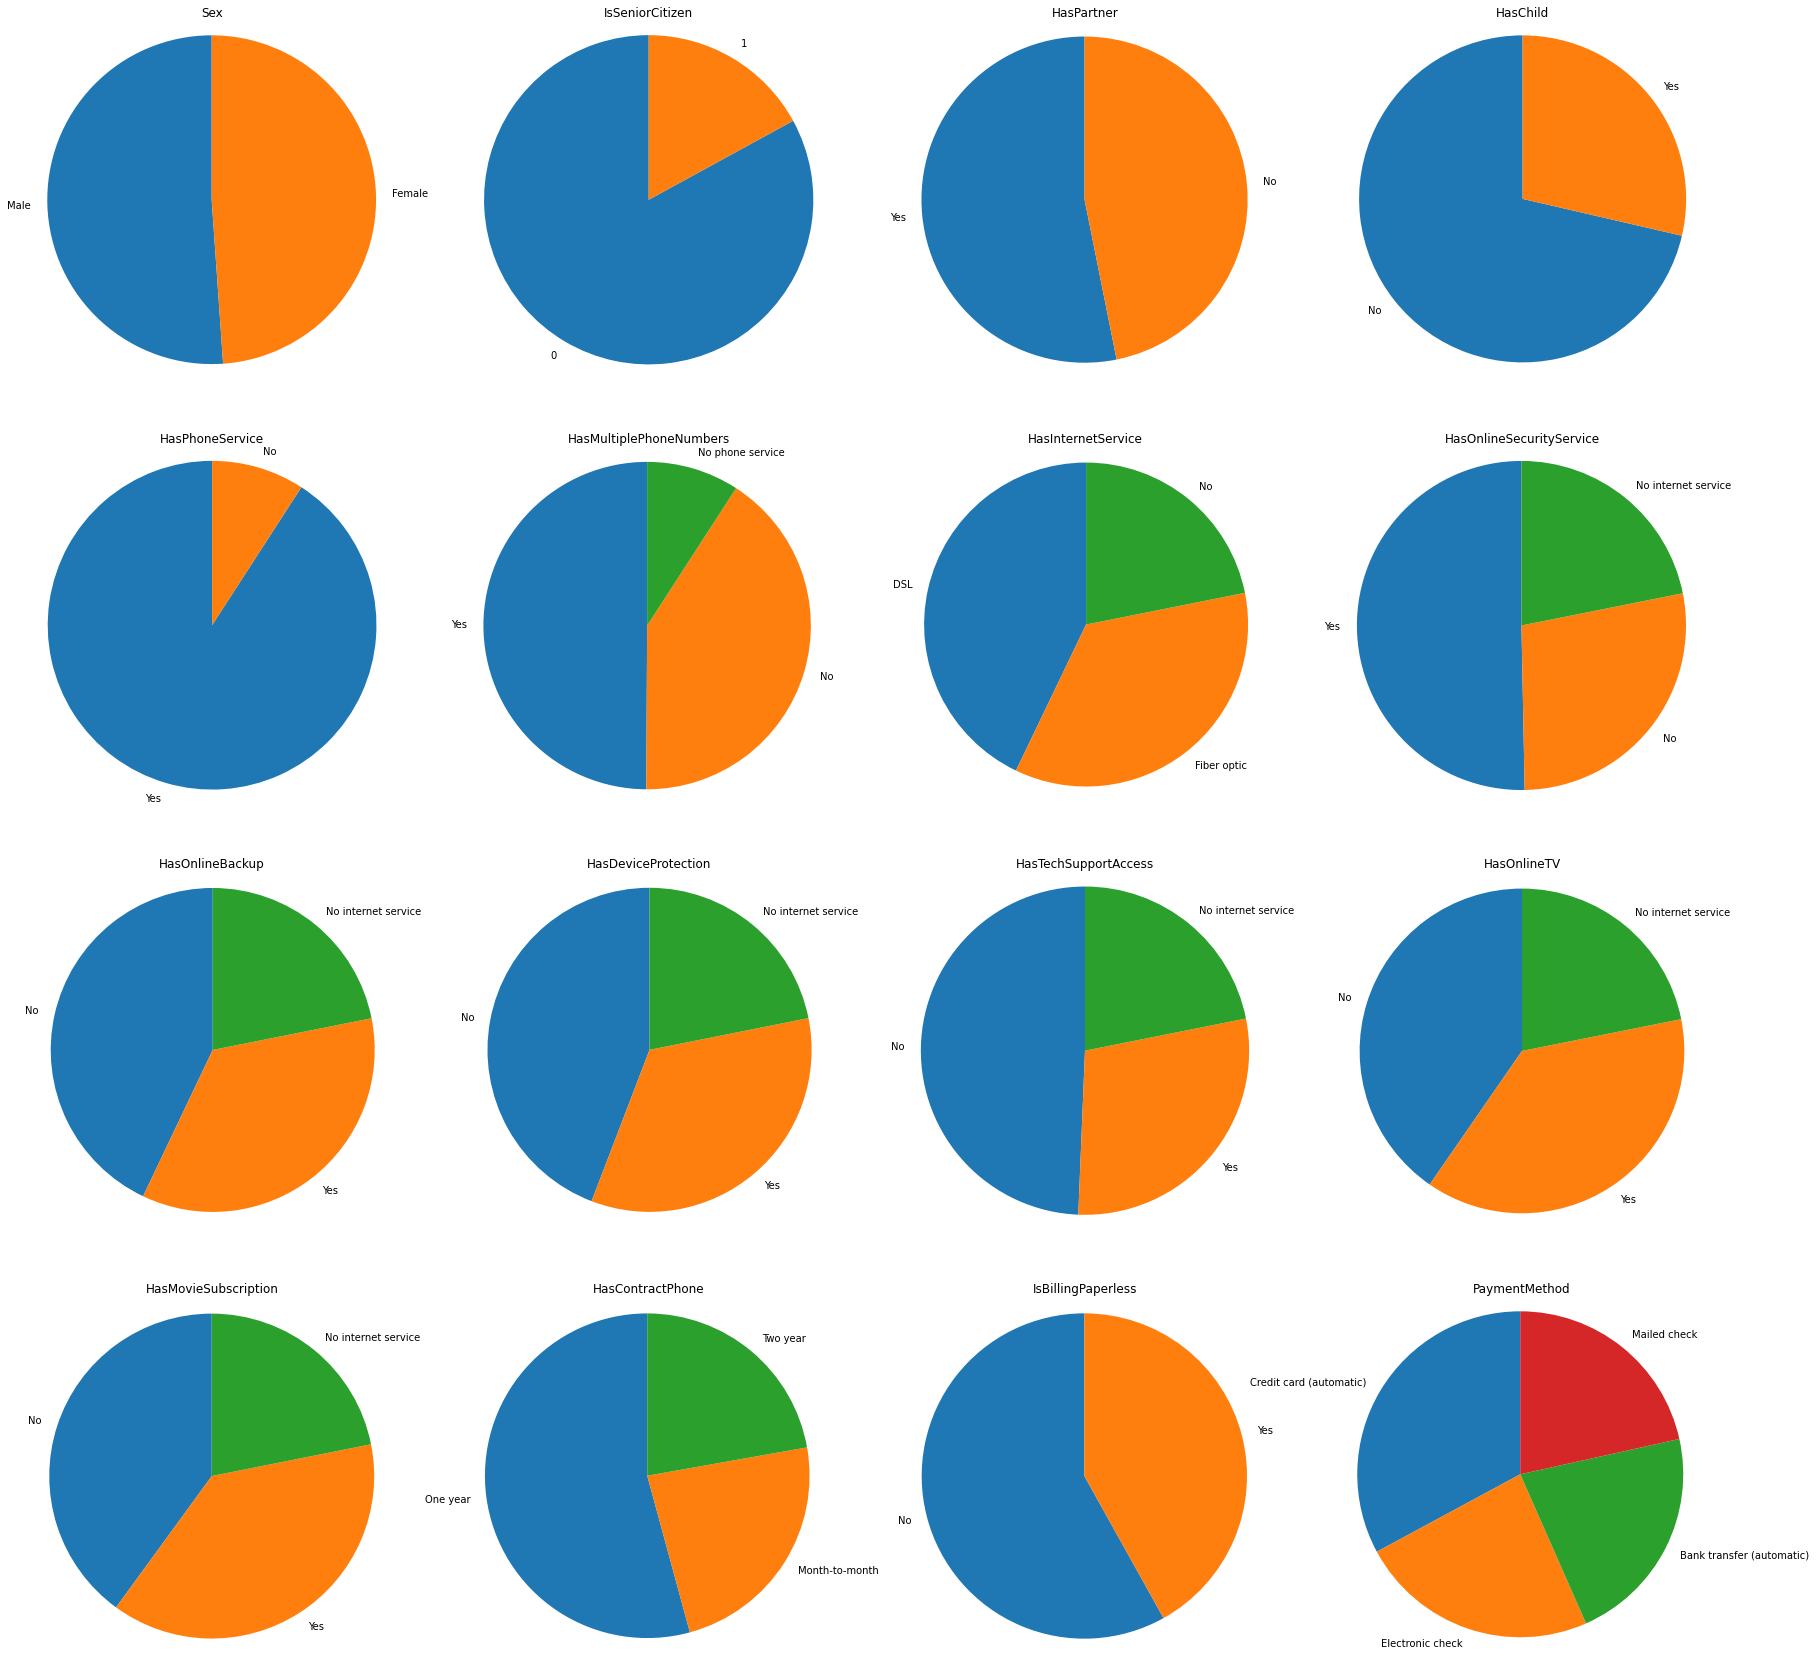

In [257]:
# working with categorical test data
test_categorical_data = test_data[categorical_columns]
figure, axes = plt.subplots(4, 4, figsize=(30, 30))
axes = axes.ravel()
for i, column in enumerate(categorical_columns):
    values = test_categorical_data[column].unique()
    values_count = test_categorical_data[column].value_counts()
    axes[i].set_title(column)
    axes[i].pie(values_count, labels=values, startangle=90)
    axes[i].axis("equal")

In [258]:
# using one-hot encoding to transform categorical data
train_dummy_features = pd.get_dummies(train_categorical_data)
test_dummy_features = pd.get_dummies(test_categorical_data)

0it [00:00, ?it/s]

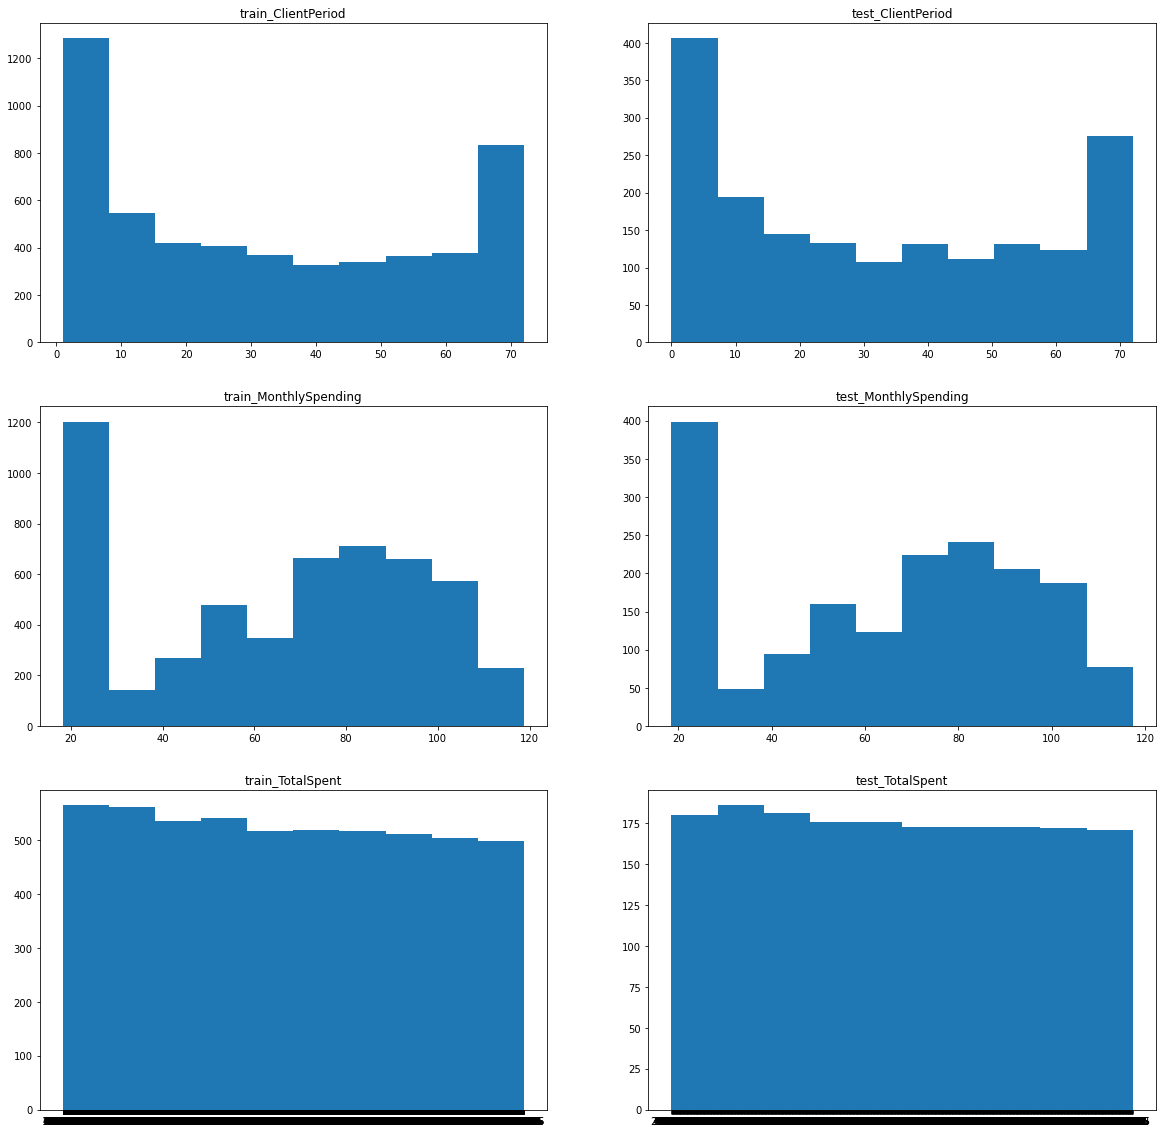

In [318]:
# working with numeric data
numeric_columns = [column for column in test_data.columns if column not in categorical_columns]
train_numeric_data = train_data[numeric_columns]
test_numeric_data = test_data[numeric_columns]
figure, axes = plt.subplots(3, 2, figsize=(20, 20))
axes = axes.ravel()
for i, column in enumerate(numeric_columns):
    axes[2 * i].set_title("train_" + column)
    axes[2 * i + 1].set_title("test_" + column)
    axes[2 * i].hist(train_numeric_data[column])
    axes[2 * i + 1].hist(test_numeric_data[column])

In [260]:
# normalization
scaler = StandardScaler()
train_numeric_data = scaler.fit_transform(train_numeric_data)
test_numeric_data = scaler.fit_transform(test_numeric_data)

<BarContainer object of 2 artists>

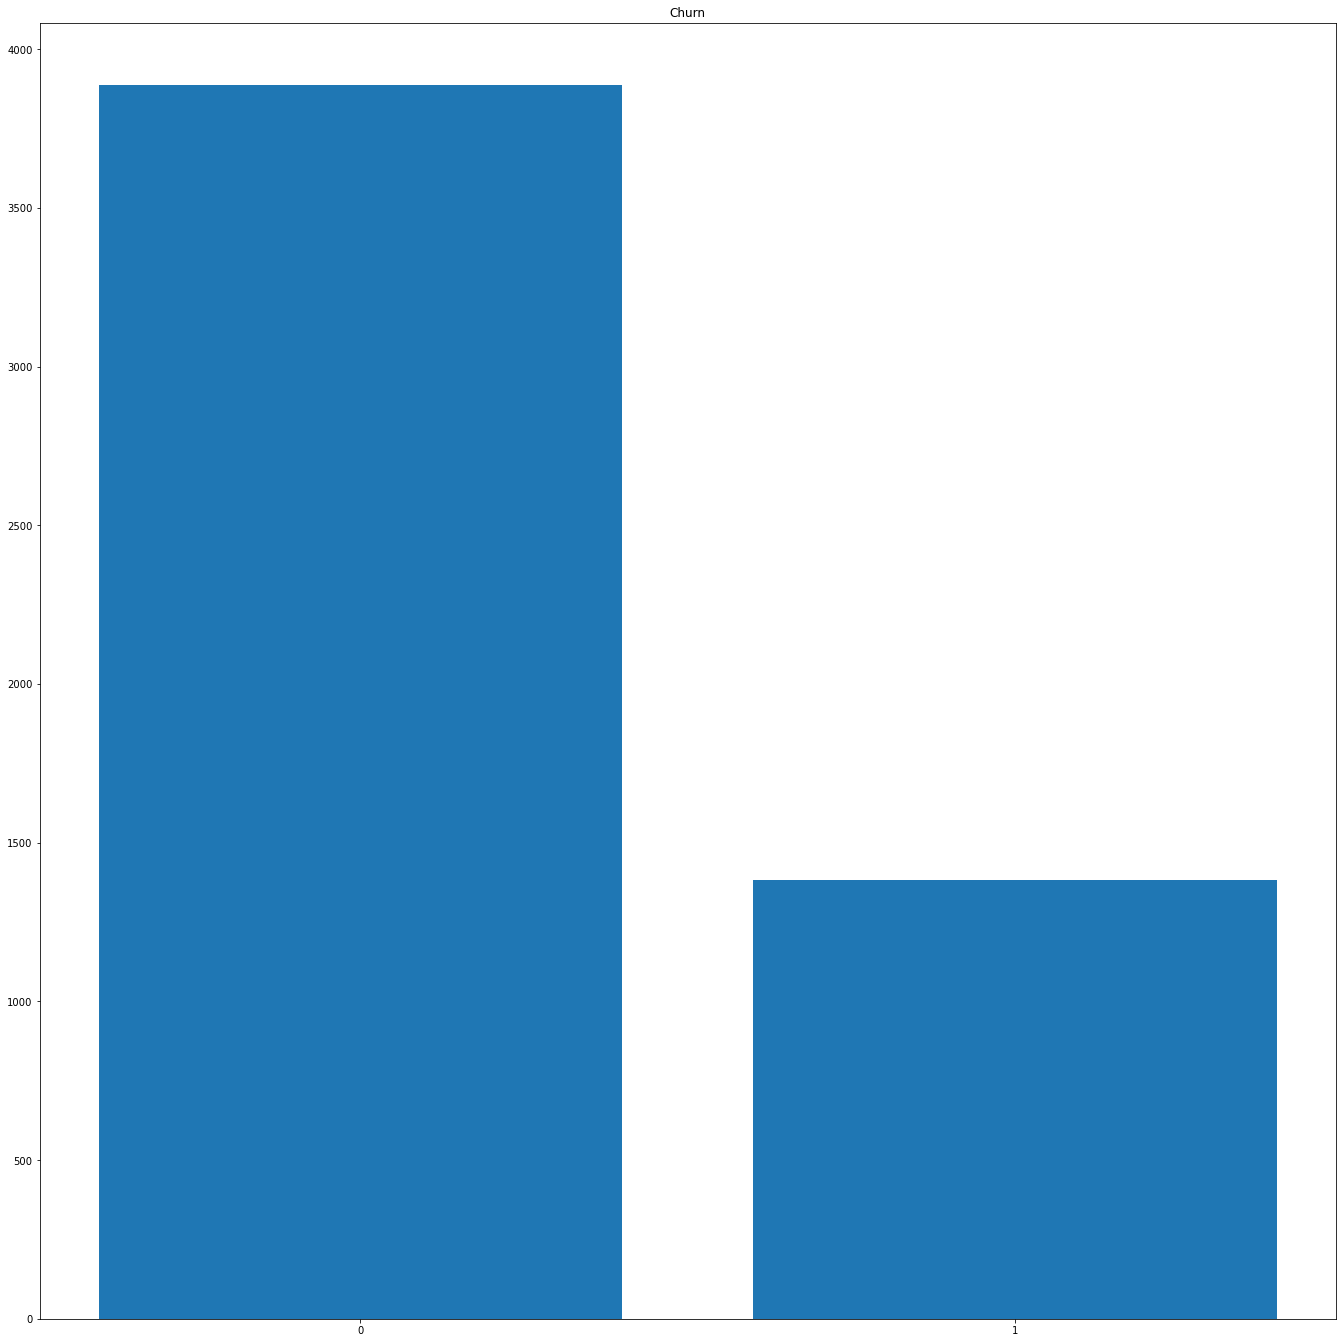

In [261]:
# Distribution of the target variable
# There are significantly more 0 values
figure = plt.figure(figsize=(18, 18))
axes = figure.add_axes([0, 0, 1, 1])
values = train_data["Churn"].unique()
values_count = train_data["Churn"].value_counts()
axes.set_title("Churn")
axes.bar(values, values_count, tick_label=values)

In [262]:
X_train = np.concatenate((train_numeric_data, train_dummy_features.values), axis=1)
X_test = np.concatenate((test_numeric_data, test_dummy_features.values), axis=1)
y_train = train_data["Churn"]

In [263]:
# using GridSearchCV to find the best parameters for different algorithms
# tried to run XGBoost classifier but it took infinite time to fit even on small batches, so i think it is a bag
# MacBook Air M1 2020 8GB
# also unable to install CatBoost due to the arm architecture
estimators = {
    "knn": KNeighborsClassifier(),
    "logit": LogisticRegression(),
    "tree": DecisionTreeClassifier(),
    "forest": RandomForestClassifier(),
    "lgbm": LGBMClassifier(),
}
knn_grid = {
    "n_neighbors": np.arange(10) + 1,
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
    "n_jobs": [-1],
}
logit_grid = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "dual": [True, False],
    "fit_intercept": [True, False],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "n_jobs": [-1],
    "C": 0.001 * 10 ** np.arange(5),
}
tree_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": 2 * np.arange(6) + 1,
    "min_samples_split": np.arange(6) + 1,
}
forest_grid = {
    "n_estimators": 50 * (np.arange(5) + 1),
    "criterion": ["gini"],
    "max_depth": np.arange(10) + 1,
    "min_samples_split": np.arange(5) + 1,
    "bootstrap": [True, False],
}
lgbm_grid = {
    "n_estimators": 50 * np.arange(10) + 50,
    "max_depth": np.arange(10) + 1,
    "num_leaves": 2 ** np.arange(8) + 1,
    "n_jobs": [-1],
    "learning_rate": 0.1 ** (np.arange(3) + 1),
}
param_grids = {"knn": knn_grid, "logit": logit_grid, "tree": tree_grid, "forest": forest_grid, "lgbm": lgbm_grid}

In [264]:
# time taken: ~130s. ROC_AUC: ~0.8076
#'best_params': {'algorithm': 'auto',
#                'n_jobs': -1,
#                'n_neighbors': 10,
#                'p': 2,
#                'weights': 'uniform'}
name = "knn"
grid_search = GridSearchCV(estimators[name], param_grids[name], cv=5, scoring="roc_auc")
start = time()
grid_search.fit(X_train, y_train)
time_taken = time() - start
estimators[name] = {
    "estimator": grid_search.best_estimator_,
    "best_params": grid_search.best_params_,
    "best_score": grid_search.best_score_,
    "time_taken": time_taken,
}

In [266]:
# time taken: ~110s. ROC_AUC: ~0.8448
# 'best_params': {'C': 10.0,
#                 'dual': False,
#                 'fit_intercept': False,
#                 'n_jobs': -1,
#                 'penalty': 'l1',
#                 'solver': 'liblinear'}
name = "logit"
grid_search = GridSearchCV(estimators[name], param_grids[name], cv=5, scoring="roc_auc")
start = time()
grid_search.fit(X_train, y_train)
time_taken = time() - start
estimators[name] = {
    "estimator": grid_search.best_estimator_,
    "best_params": grid_search.best_params_,
    "best_score": grid_search.best_score_,
    "time_taken": time_taken,
}

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalt

In [268]:
# time taken: ~7s. ROC_AUC: ~0.8268
# 'best_params': {'criterion': 'entropy',
#                 'max_depth': 5,
#                 'min_samples_split': 6,
#                 'splitter': 'best'}
name = "tree"
grid_search = GridSearchCV(estimators[name], param_grids[name], cv=5, scoring="roc_auc")
start = time()
grid_search.fit(X_train, y_train)
time_taken = time() - start
estimators[name] = {
    "estimator": grid_search.best_estimator_,
    "best_params": grid_search.best_params_,
    "best_score": grid_search.best_score_,
    "time_taken": time_taken,
}

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 238, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The sc

In [270]:
# time taken: ~550s. ROC_AUC: ~0.8445
# 'best_params': {'bootstrap': True,
#                 'criterion': 'gini',
#                 'max_depth': 6,
#                 'min_samples_split': 4,
#                 'n_estimators': 200}
name = "forest"
grid_search = GridSearchCV(estimators[name], param_grids[name], cv=5, scoring="roc_auc")
start = time()
grid_search.fit(X_train, y_train)
time_taken = time() - start
estimators[name] = {
    "estimator": grid_search.best_estimator_,
    "best_params": grid_search.best_params_,
    "best_score": grid_search.best_score_,
    "time_taken": time_taken,
}

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/joblib/parallel.py", line 859, in 

In [272]:
# time taken: ~1900s. ROC_AUC: 0.8481
# 'best_params': {'learning_rate': 0.1,
#                 'max_depth': 1,
#                 'n_estimators': 150,
#                 'n_jobs': -1,
#                 'num_leaves': 2}
name = "lgbm"
grid_search = GridSearchCV(estimators[name], param_grids[name], cv=5, scoring="roc_auc")
start = time()
grid_search.fit(X_train, y_train)
time_taken = time() - start
estimators[name] = {
    "estimator": grid_search.best_estimator_,
    "best_params": grid_search.best_params_,
    "best_score": grid_search.best_score_,
    "time_taken": time_taken,
}

In [273]:
estimators

{'knn': {'estimator': KNeighborsClassifier(n_jobs=-1, n_neighbors=10),
  'best_params': {'algorithm': 'auto',
   'n_jobs': -1,
   'n_neighbors': 10,
   'p': 2,
   'weights': 'uniform'},
  'best_score': 0.8076779516864813,
  'time_taken': 130.22067499160767},
 'logit': {'estimator': LogisticRegression(C=10.0, fit_intercept=False, n_jobs=-1, penalty='l1',
                     solver='liblinear'),
  'best_params': {'C': 10.0,
   'dual': False,
   'fit_intercept': False,
   'n_jobs': -1,
   'penalty': 'l1',
   'solver': 'liblinear'},
  'best_score': 0.8448637143517626,
  'time_taken': 102.36124110221863},
 'tree': {'estimator': DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=6),
  'best_params': {'criterion': 'entropy',
   'max_depth': 5,
   'min_samples_split': 6,
   'splitter': 'best'},
  'best_score': 0.8268596047263765,
  'time_taken': 5.722017049789429},
 'forest': {'estimator': RandomForestClassifier(max_depth=6, min_samples_split=4, n_estimators=200),
  'b

In [284]:
def generate_batches(X, y, batch_size=100):
    indexes = np.random.permutation(X.shape[0])
    for batch in range(X.shape[0] // batch_size):
        X_batch = X[indexes[batch * batch_size : (batch + 1) * batch_size]]
        y_batch = y[indexes[batch * batch_size : (batch + 1) * batch_size]]
        yield X_batch, y_batch

In [309]:
# I don't know why roc_auc changes so strangely depending on the batch_size
for batch_size in tqdm(500 * np.arange(1, 11)):
    knn_roc, logit_roc, tree_roc, forest_roc, lgbm_roc = [0 for i in range(5)]
    for X_batch, y_batch in generate_batches(X_train, y_train.values, batch_size=batch_size):
        knn_predictions = estimators["knn"]["estimator"].predict_proba(X_batch)[:, 1]
        logit_predictions = estimators["logit"]["estimator"].predict_proba(X_batch)[:, 1]
        tree_predictions = estimators["tree"]["estimator"].predict_proba(X_batch)[:, 1]
        forest_predictions = estimators["forest"]["estimator"].predict_proba(X_batch)[:, 1]
        lgbm_predictions = estimators["lgbm"]["estimator"].predict_proba(X_batch)[:, 1]
        knn_roc += roc_auc_score(y_batch, knn_predictions)
        logit_roc += roc_auc_score(y_batch, logit_predictions)
        tree_roc += roc_auc_score(y_batch, tree_predictions)
        forest_roc += roc_auc_score(y_batch, forest_predictions)
        lgbm_roc += roc_auc_score(y_batch, lgbm_predictions)
    knn_roc /= X_train.shape[0] / batch_size
    logit_roc /= X_train.shape[0] / batch_size
    tree_roc /= X_train.shape[0] / batch_size
    forest_roc /= X_train.shape[0] / batch_size
    lgbm_roc /= X_train.shape[0] / batch_size
    print(batch_size)
    print(knn_roc, logit_roc, tree_roc, forest_roc, lgbm_roc)

  0%|          | 0/10 [00:00<?, ?it/s]

500
0.8297328187912292 0.8051355568982568 0.8059769025002351 0.825282384799188 0.8102710543539479
1000
0.8284468010831141 0.8032209829218756 0.8050456985118584 0.8240159478874592 0.8081107155267491
1500
0.7489621962562443 0.7265865077229733 0.727946150292374 0.7456660817574525 0.7314312336923319
2000
0.6627586239602505 0.6424679315599645 0.6431259771315732 0.6583567516795319 0.6458502010774994
2500
0.828806937403271 0.8035314161388766 0.8052208997732434 0.8241466248192576 0.8081289523095139
3000
0.4957064940438605 0.47894631503921964 0.4788369156549991 0.491831919092853 0.48183565105869813
3500
0.5819994353932588 0.5625741369804825 0.5660611434366357 0.5777711648778578 0.5663685172175945
4000
0.6641545397876883 0.643371104135688 0.6450038979558294 0.659172962590814 0.6458566852513666
4500
0.7453128078585031 0.7244159102357529 0.7258807373169164 0.742876420652544 0.7282624376451787
5000
0.829830786224983 0.8057205051089609 0.8068957915101084 0.8259191273354684 0.8101316411699544


In [315]:
# use lgbm models to predict on test data

predictions = estimators["lgbm"]["estimator"].predict_proba(X_test)
predictions = predictions[:, 1]
submission = pd.DataFrame({"Id": np.arange(X_test.shape[0]), "Churn": predictions})
with open("Files/lgbm_submission.csv", "w") as submission_file:
    submission_file.write(submission.to_csv(index=False))